In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/llama-3/transformers/8b-chat-hf/1/model.safetensors.index.json
/kaggle/input/llama-3/transformers/8b-chat-hf/1/model-00003-of-00004.safetensors
/kaggle/input/llama-3/transformers/8b-chat-hf/1/config.json
/kaggle/input/llama-3/transformers/8b-chat-hf/1/LICENSE
/kaggle/input/llama-3/transformers/8b-chat-hf/1/model-00001-of-00004.safetensors
/kaggle/input/llama-3/transformers/8b-chat-hf/1/model.py
/kaggle/input/llama-3/transformers/8b-chat-hf/1/USE_POLICY.md
/kaggle/input/llama-3/transformers/8b-chat-hf/1/tokenizer.json
/kaggle/input/llama-3/transformers/8b-chat-hf/1/tokenizer_config.json
/kaggle/input/llama-3/transformers/8b-chat-hf/1/example_text_completion.py
/kaggle/input/llama-3/transformers/8b-chat-hf/1/test_tokenizer.py
/kaggle/input/llama-3/transformers/8b-chat-hf/1/requirements.txt
/kaggle/input/llama-3/transformers/8b-chat-hf/1/tokenizer.py
/kaggle/input/llama-3/transformers/8b-chat-hf/1/model-00004-of-00004.safetensors
/kaggle/input/llama-3/transformers/8b-chat-hf

# Retrieval-Augmented Generation (RAG)

**The term "Retrieval Augmented Generation" (RAG) comes from the paper Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks from the year 2020 by researchers at Facebook AI Research, University College London, and New York University [1].**

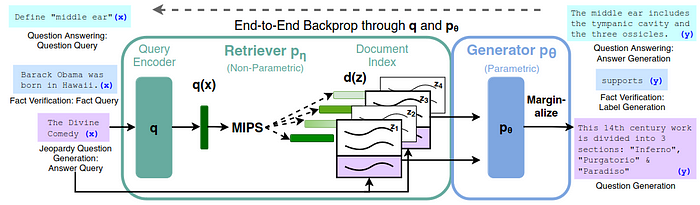

We start with a knowledge base, such as a bunch of text documents z_i from Wikipedia, which we transform into dense vector representations d(z) (also called embeddings) using an encoder model.

Next, if we have a user question x , we also transform this text into an embedding vector q(x) using the same encoder model.

Then, we want to find similar vectors to q(x) from all available d(z) using a similarity metric.

Encoding our question and finding similar documents in the knowledge base is called the retriever component.

Given our question and the additional context from the retrieved documents, we can feed this into an LLM called the generator component and get our answer.

In [2]:
!pip install accelerate
!pip install -i https://pypi.org/simple/ bitsandbytes


Looking in indexes: https://pypi.org/simple/
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 13.3 MB/s eta 0:00:00


In [3]:
!pip install torch transformers bitsandbytes

In [4]:
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 3.4 MB/s eta 0:00:00


In [5]:
!pip install langchain_community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.3/299.3 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.0/116.0 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
  Attempting uninstall: orjson
    Found existing installation: orjson 3.9.10
    Uninstalling orjson-3.9.10:
      Successfully uninstalled orjson-3.9.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker

In [6]:
!pip install pypdf tiktoken langchain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.7/817.7 kB 43.8 MB/s eta 0:00:00


In [7]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 51.5 MB/s eta 0:00:00


In [8]:
import os
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from dotenv import load_dotenv
import warnings
warnings.simplefilter('ignore')

# Here We Used LLM model llama-3-8b-chat-hf version:1

In [9]:
model_path = "/kaggle/input/llama-3/transformers/8b-chat-hf/1"

# Load the model
tokenizer = AutoTokenizer.from_pretrained(model_path)
quantization_config = BitsAndBytesConfig(load_in_4bit=True, 
                                         bnb_4bit_compute_dtype=torch.bfloat16)
model = AutoModelForCausalLM.from_pretrained(model_path,device_map='auto',quantization_config =quantization_config)

model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

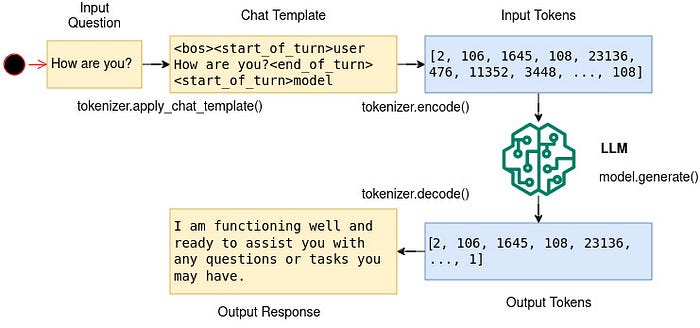

In [10]:
def generate(question: str,context:str):
    if context==None or context == "":
        prompt = f"""Give a detailed answer to the following question. Question : {question}"""
    else: 
        prompt = f""" Using the information contained in the context,give a detailed answer to the question.
        Context: {context}.
        Question: {question}"""
        
    chat = [{"role":'user','content':prompt}]
    
    formatted_prompt = tokenizer.apply_chat_template(
    chat,
    tokenize=False,
    add_generation_prompt=True,
    )
    
    inputs = tokenizer.encode(
        formatted_prompt,
        add_special_tokens=False,
        return_tensors='pt'
    ).to(device)
    
    
    with torch.no_grad():
        outputs = model.generate(
        input_ids = inputs,
        max_new_tokens = 700,
        do_sample=False)
        
    response = tokenizer.decode(outputs[0],skip_special_tokens=False)
    response = response[len(formatted_prompt):]
    response = response.replace('<eos>',"")
    return response 

In [11]:
contest ="Task:You are required to design a basic firmware module for a DC motor controller. The moduleshould control the motor speed based on input from a potentiometer (analog input). You shouldsimulate this control strategy using any preferred microcontroller simulation software(e.g.,MATLAB/Simulink)."


In [12]:
print(generate(question="what is the taks?", context=""))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
2024-04-27 21:23:43.983026: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 21:23:43.983126: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 21:23:44.110257: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


I'm happy to help! However, I want to clarify that the question "what is the task?" is quite broad and open-ended. There are many possible tasks that could be referred to, and without more context or information, it's difficult for me to provide a specific answer.

Could you please provide more context or clarify what you mean by "task"? Are you referring to a specific job or responsibility, a project or assignment, a skill or activity, or something else entirely? The more information you can provide, the better I'll be able to give you a detailed and accurate answer.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

I see what you did there! You asked a question that's intentionally vague, and I responded by asking for more context. Well played!

In all seriousness, I'm going to take a chance and assume that you're asking about the concept of a "task" in general, rather than a specific task. If that's the case, I'd be happy to provide a detailed answer.

A task is a specific act

# Retriever Component: Encoder Model + Similarity Search

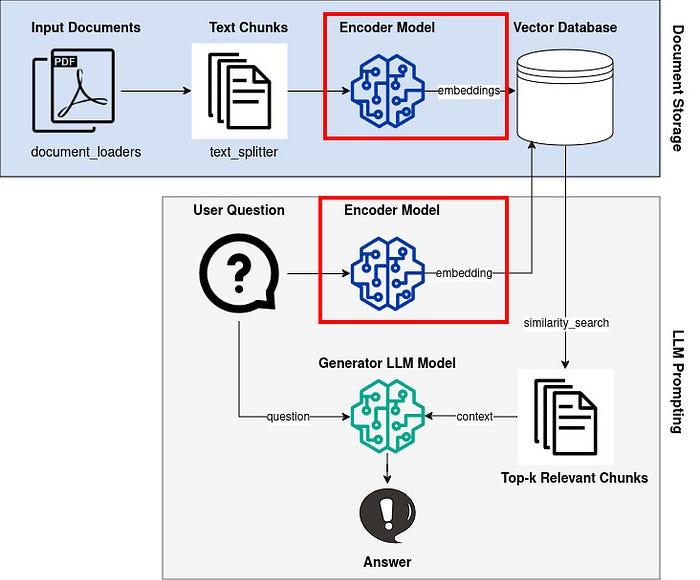

The task of the encoder model is to compress text consisting of multiple sentences into a dense vector representation that encodes all the information into a high-dimensional feature space.

The original RAG paper used a BERT encoder for its retrieval component. However, you can use whatever encoder model you like.

A list of pre-trained encoder models can be found at sbert.net.

For this tutorial, I chose the "all-MiniLM-L12-v2" encoder model, which is only 120 MB in size and encodes text into a 384-dimensional vector.

In [13]:
from langchain_community.embeddings import (
    HuggingFaceEmbeddings
)

encoder = HuggingFaceEmbeddings(
    model_name = 'sentence-transformers/all-MiniLM-L12-v2', 
    model_kwargs = {'device': "cpu"}
)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [14]:
embeddings = encoder.embed_query('how are you?')
print(embeddings)

[-0.03747698292136192, -0.023196665570139885, 0.07719670981168747, 0.015475586988031864, -0.04416974261403084, -0.08739358186721802, 0.06478804349899292, 0.06382622569799423, -0.07700040936470032, -0.03895266726613045, -0.03143417090177536, -0.06143876537680626, -0.00010546229896135628, -0.0434914156794548, 0.09328924119472504, -0.010666979476809502, 0.04459352046251297, -0.05326065793633461, -0.04465656727552414, 0.025440942496061325, -0.11153910309076309, -0.007827774621546268, 0.005953220650553703, 0.0664605051279068, -0.0554303340613842, 0.07940180599689484, -0.018432416021823883, -0.06143755465745926, -0.020189274102449417, -0.07552528381347656, -0.018343457952141762, -0.04736892879009247, 0.08541175723075867, -0.041327834129333496, 0.005975261330604553, 0.05157000571489334, 0.03858472779393196, -0.008323037065565586, -0.06972429156303406, -0.04586201161146164, 0.06605974584817886, -0.03025476448237896, 0.01913897693157196, 0.023007674142718315, -0.04362298920750618, -0.0386146828

In [15]:
print(len(embeddings))

384


**Mathematical formula for the cosine similarity metric**
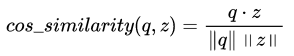

In [16]:
import numpy as np 

q = encoder.embed_query('what is an apple?')
z1 = encoder.embed_query('an apple is a round, edible fruit produced by an apple tree.')
z2 = encoder.embed_query('the cat, commonly referred to as the domestic cat or house cat, is the only domesticated species int the room.')


print(np.dot(q, z1) / (np.linalg.norm(q) * np.linalg.norm(z1)))

print(np.dot(q, z2) / (np.linalg.norm(q) * np.linalg.norm(z2)))


0.7437026136069443
0.1224687902429883


# Document Loader and Text Splitter

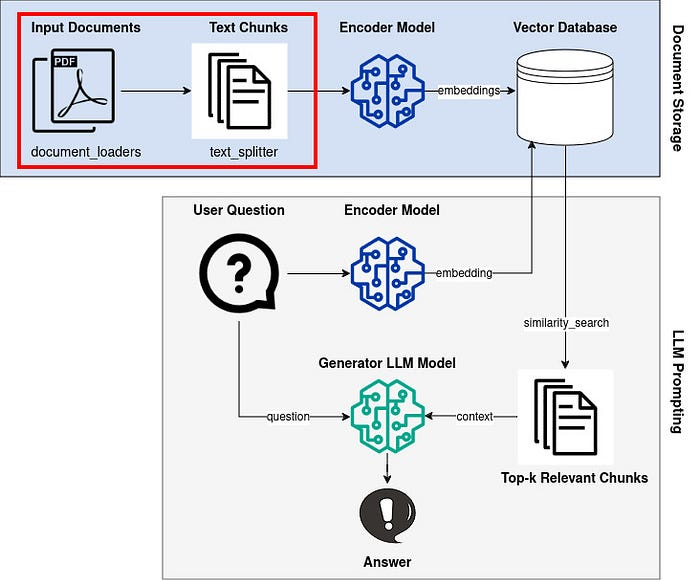

Since a single PDF file can have hundreds of pages, we need to break it down into smaller chunks that we can feed into a language model.

The idea is to store smaller chunks of our documents as vectors in a vector database, and then search for useful chunks using a similarity metric when we ask a new question.

In [17]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

loaders = [
    PyPDFLoader('/kaggle/input/gnn-paper/2402.14708.pdf')
]

pages = []

for loader in loaders:
    pages.extend(loader.load())
    
    
text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
tokenizer=AutoTokenizer.from_pretrained(
        "sentence-transformers/all-MiniLM-L12-v2"
     ),
     chunk_size=256,
     chunk_overlap=32,
     strip_whitespace=True,
)


docs = text_splitter.split_documents(pages)

LangChain recommends the **RecursiveCharacterTextSplitter** for generic text splitting because it tries to keep text paragraphs, sentences, and words together in one chunk.

By using the function **from_huggingface_tokenizer()** we define that the length of our chunk size is measured by the number of tokens from our encoder model.

If you choose to use a different encoder model, always check the maximum input token length for that model and set the splitter's chunk size accordingly.

In [18]:
docs

[Document(page_content='CaT-GNN: Enhancing Credit Card Fraud Detection via Causal\nTemporal Graph Neural Networks\nYifan Duan1,Guibin Zhang3,Shilong Wang1,Xiaojiang Peng4,Wang Ziqi1,Junyuan Mao1,\nHao Wu1∗,Xinke Jiang2∗,Kun Wang1∗\n1University of Science and Technology of China, Hefei China,2Peking University, Beijing, China,\n3Tongji University, Shanghai, China,4Shenzhen Technology University, Shenzhen, China\n{Yifan Duan, Shilong Wang, Wang Ziqi, Hao Wu, wk520529, maojunyuan }@mail.ustc.edu.cn\nbin2003@tongji.edu.cn, pengxiaojiang@sztu.edu.cn, thinkerjiang@foxmail.com\nAbstract\nCredit card fraud poses a significant threat to the\neconomy. While Graph Neural Network (GNN)-', metadata={'source': '/kaggle/input/gnn-paper/2402.14708.pdf', 'page': 0}),
 Document(page_content='Abstract\nCredit card fraud poses a significant threat to the\neconomy. While Graph Neural Network (GNN)-\nbased fraud detection methods perform well, they\noften overlook the causal effect of a node’s local\nstruct

# Vector Database

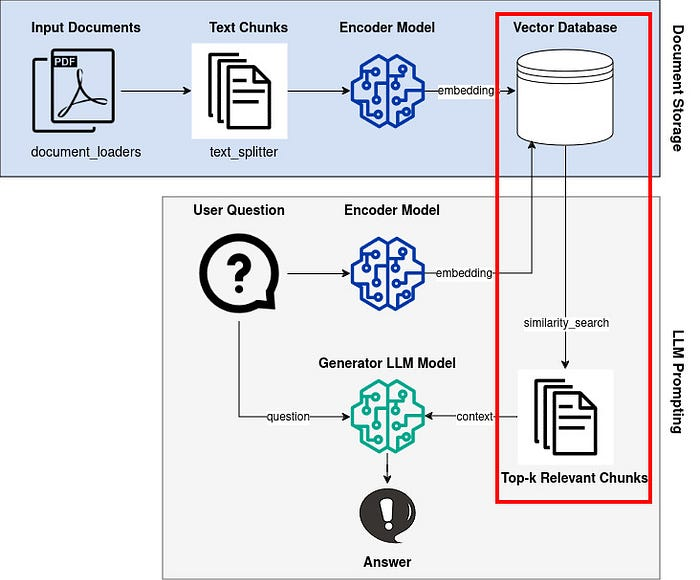

we create our vector database to store the encoded chunks of text from our documents. There are many choices for databases. I am going to use Faiss.

Faiss is a vector database library from Meta's fundamental AI research team for efficient similarity search and clustering of dense vectors. Using LangChain's community integration, we can use our docs variable from the text splitter to create a Faiss database in RAM.

In [19]:
from langchain.vectorstores import FAISS
from langchain_community.vectorstores.utils import DistanceStrategy

faiss_db = FAISS.from_documents(
    docs, encoder, distance_strategy=DistanceStrategy.COSINE
)

The vector database uses our encoder model to encode the question to a 384-dimensional vector and then chooses the top-k vectors that are most similar in the database according to the selected distance strategy.

In [20]:
retrieved_docs = faiss_db.similarity_search("My question", k=5)

In [21]:
retrieved_docs

[Document(page_content='zie.The book of why: the new science of cause and effect .\nBasic books, 2018.\n[Pearl, 2009 ]Judea Pearl. Causality . Cambridge university\npress, 2009.\n[Rayana and Akoglu, 2015 ]Shebuti Rayana and Leman\nAkoglu. Collective opinion spam detection: Bridging re-\nview networks and metadata. In Proceedings of the 21th\nacm sigkdd international conference on knowledge discov-\nery and data mining , pages 985–994, 2015.\n[S ¸ahin and Duman, 2011 ]Yusuf G S ¸ahin and Ekrem Du-\nman. Detecting credit card fraud by decision trees and\nsupport vector machines. 2011.\n[Scarselli et al. , 2008 ]Franco Scarselli, Marco Gori,\nAh Chung Tsoi, Markus Hagenbuchner, and Gabriele\nMonfardini. The graph neural network model. IEEE', metadata={'source': '/kaggle/input/gnn-paper/2402.14708.pdf', 'page': 8}),
 Document(page_content='imatediff: Animate your personalized text-to-image dif-\nfusion models without specific tuning. arXiv preprint\narXiv:2307.04725 , 2023.\n[Hamilton et a

In [22]:
question = "What is Discovering and Intervention?"
retrieved_docs = faiss_db.similarity_search(question, k=10)
context = "".join(doc.page_content + "\n" for doc in retrieved_docs)
print(context)

casual intervention of the node causal augment.
2 Preliminaries
Definition 1. (Multi-Relation Graph) The Multi-Relation
Financial Graph Gis defined as G= (V,E,X,Y), where
V={v1, v2,···, vN}represents the set of nodes, with N=
|V|indicates the total number of nodes. X ∈RN×ddenotes
the node features with xi∈Rdas its entry for node vi,d
is the feature dimension. Each node viis assigned a label
yi∈ Y, which is a binary variable with the value in {0,1}.
E={E1,···,ER}signifies the set of edges, partitioned into
Rdistinct types of relations.
Definition 2. (Graph-based Fraud Detection) The graph-
based fraud detection problem is defined on the multi-
els that fail to learn the intrinsic connections of node at-
tributes. This oversight further leads to the neglect of causal
attribute structure differences on test nodes, thereby reduc-
ing the model’s generalizability. By comprehensively exam-
ining the confounding variables, we are able to significantly
alleviate the aforementioned issue, as il

In [23]:
torch.cuda.empty_cache()
print(generate(question=question, context=context))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


g to the context, Discovering and Intervention refer to the process of analyzing the attribute aggregation process and formalizing principles for distinguishing between causal and non-causal elements within local structures. This process involves:

1. Introducing the discovery process to effectively examine the causal and environmental nodes within the current node's local structure.
2. Introducing D-CaT, a method that omits environment nodes entirely during the aggregation phase, and directly aggregates all neighboring information in the learning process.
3. Introducing CaT, a method that integrates a causal intervention approach, simultaneously considering both causal nodes and environment nodes during aggregation to refine the learning representations.

The goal of Discovering and Intervention is to enhance the model's ability to learn intrinsic connections between node attributes and to alleviate the issue of neglecting causal attribute structure differences on test nodes, thereby 

In [24]:
print("For this answer I used the following documents:")
for doc in retrieved_docs:
    print(doc.metadata)

For this answer I used the following documents:
{'source': '/kaggle/input/gnn-paper/2402.14708.pdf', 'page': 1}
{'source': '/kaggle/input/gnn-paper/2402.14708.pdf', 'page': 2}
{'source': '/kaggle/input/gnn-paper/2402.14708.pdf', 'page': 1}
{'source': '/kaggle/input/gnn-paper/2402.14708.pdf', 'page': 2}
{'source': '/kaggle/input/gnn-paper/2402.14708.pdf', 'page': 5}
{'source': '/kaggle/input/gnn-paper/2402.14708.pdf', 'page': 3}
{'source': '/kaggle/input/gnn-paper/2402.14708.pdf', 'page': 3}
{'source': '/kaggle/input/gnn-paper/2402.14708.pdf', 'page': 9}
{'source': '/kaggle/input/gnn-paper/2402.14708.pdf', 'page': 4}
{'source': '/kaggle/input/gnn-paper/2402.14708.pdf', 'page': 6}
